In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/converted.zip
!unzip -q dataset/test9classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
class Residualblock(nn.Module):
    def __init__(self, in_channel, out_channel, Conv=False, strides=1):
        super().__init__()
        self.convolution1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=strides)
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.convolution2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)

        if Conv:
            self.convolution3 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides)
        else:
            self.convolution3 = None

    def forward(self, X):
        out = F.relu(self.batchnorm1(self.convolution1(X)))
        out = self.batchnorm2(self.convolution2(out))
        if self.convolution3:
            X = self.convolution3(X)
        out += X
        return F.relu(out)

def residualBlock(in_channel, out_channel, num_residuals, first_block=False):
    blks = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blks.append(Residualblock(in_channel, out_channel, Conv=True,
            strides=2))
        else:
            blks.append(Residualblock(out_channel, out_channel))
    
    return blks

class ResNet(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*residualBlock(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*residualBlock(64, 128, 2))
        self.b4 = nn.Sequential(*residualBlock(128, 256, 2))
        self.b5 = nn.Sequential(*residualBlock(256, 512, 2))
        self.finalLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),nn.Linear(512, n_classes))

        self.b1.apply(self.initialweight)
        self.b2.apply(self.initialweight)
        self.b3.apply(self.initialweight)
        self.b4.apply(self.initialweight)
        self.b5.apply(self.initialweight)
        self.finalLayer.apply(self.initialweight)

    def initialweight(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        


    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.finalLayer(out)

        return out

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
with open('test9classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']
4050
4050


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 5 #
batch_size_val = 5

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('converted/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test9classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: DEB


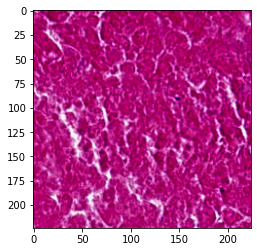

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ResNet(input_channel=3, n_classes=9).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("ResNetSGD.pth"):
        os.remove("ResNetSGD.pth")
      torch.save(model.state_dict(), 'ResNetSGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ResNet(input_channel=3, n_classes=9).to(device)
  model.load_state_dict(torch.load('ResNetSGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-6-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1525

Test: Average loss: 0.8557, Accuracy: 3712/5400 (68.74%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7470

Test: Average loss: 0.6579, Accuracy: 4189/5400 (77.57%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5804

Test: Average loss: 0.4760, Accuracy: 4457/5400 (82.54%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4639

Test: Average loss: 0.3883, Accuracy: 4703/5400 (87.09%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3790

Test: Average loss: 0.4371, Accuracy: 4533/5400 (83.94%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3275

Test: Average loss: 0.1892, Accuracy: 5063/5400 (93.76%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2830

Test: Average loss: 0.2787, Accuracy: 4868/5400 (90.15%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2441

Test: Average loss: 0.2644, Accuracy: 4873/5400 (90.24%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2189

Test: Average loss: 0.1823, Accuracy: 5050/5400 (93.52%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1919

Test: Average loss: 0.1935, Accuracy: 5049/5400 (93.50%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1704

Test: Average loss: 0.1530, Accuracy: 5109/5400 (94.61%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1623

Test: Average loss: 0.1767, Accuracy: 5056/5400 (93.63%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1363

Test: Average loss: 0.1167, Accuracy: 5182/5400 (95.96%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1266

Test: Average loss: 0.1485, Accuracy: 5124/5400 (94.89%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1155

Test: Average loss: 0.1270, Accuracy: 5168/5400 (95.70%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1072

Test: Average loss: 0.1189, Accuracy: 5169/5400 (95.72%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0908

Test: Average loss: 0.1020, Accuracy: 5210/5400 (96.48%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0826

Test: Average loss: 0.1052, Accuracy: 5217/5400 (96.61%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0811

Test: Average loss: 0.1579, Accuracy: 5103/5400 (94.50%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0636

Test: Average loss: 0.1398, Accuracy: 5147/5400 (95.31%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0581

Test: Average loss: 0.0983, Accuracy: 5210/5400 (96.48%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0466

Test: Average loss: 0.1101, Accuracy: 5209/5400 (96.46%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0561

Test: Average loss: 0.1405, Accuracy: 5163/5400 (95.61%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0413

Test: Average loss: 0.1897, Accuracy: 5029/5400 (93.13%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0419

Test: Average loss: 0.1145, Accuracy: 5199/5400 (96.28%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0355

Test: Average loss: 0.1075, Accuracy: 5200/5400 (96.30%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0313

Test: Average loss: 0.1191, Accuracy: 5198/5400 (96.26%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0302

Test: Average loss: 0.1011, Accuracy: 5217/5400 (96.61%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0389

Test: Average loss: 0.1122, Accuracy: 5213/5400 (96.54%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0162

Test: Average loss: 0.1064, Accuracy: 5230/5400 (96.85%)

Test: Average loss: 0.1150, Accuracy: 3925/4050 (96.91%)

Experiment:  2
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1870

Test: Average loss: 0.8561, Accuracy: 3646/5400 (67.52%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7383

Test: Average loss: 0.4570, Accuracy: 4465/5400 (82.69%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5540

Test: Average loss: 0.3368, Accuracy: 4791/5400 (88.72%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4311

Test: Average loss: 0.2684, Accuracy: 4901/5400 (90.76%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3640

Test: Average loss: 0.2336, Accuracy: 4967/5400 (91.98%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3016

Test: Average loss: 0.2340, Accuracy: 4967/5400 (91.98%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2678

Test: Average loss: 0.2826, Accuracy: 4884/5400 (90.44%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2365

Test: Average loss: 0.1642, Accuracy: 5103/5400 (94.50%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2190

Test: Average loss: 0.1429, Accuracy: 5145/5400 (95.28%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1794

Test: Average loss: 0.1549, Accuracy: 5097/5400 (94.39%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1602

Test: Average loss: 0.1508, Accuracy: 5124/5400 (94.89%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1519

Test: Average loss: 0.2115, Accuracy: 5024/5400 (93.04%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1366

Test: Average loss: 0.1076, Accuracy: 5196/5400 (96.22%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1159

Test: Average loss: 0.1369, Accuracy: 5165/5400 (95.65%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1031

Test: Average loss: 0.2380, Accuracy: 4967/5400 (91.98%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0852

Test: Average loss: 0.2903, Accuracy: 4914/5400 (91.00%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0845

Test: Average loss: 0.1534, Accuracy: 5141/5400 (95.20%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0729

Test: Average loss: 0.1135, Accuracy: 5186/5400 (96.04%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0621

Test: Average loss: 0.1203, Accuracy: 5170/5400 (95.74%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0563

Test: Average loss: 0.1404, Accuracy: 5125/5400 (94.91%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0497

Test: Average loss: 0.1629, Accuracy: 5139/5400 (95.17%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0470

Test: Average loss: 0.1347, Accuracy: 5168/5400 (95.70%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0545

Test: Average loss: 0.1524, Accuracy: 5140/5400 (95.19%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0356

Test: Average loss: 0.1338, Accuracy: 5168/5400 (95.70%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0373

Test: Average loss: 0.1169, Accuracy: 5192/5400 (96.15%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0361

Test: Average loss: 0.1121, Accuracy: 5204/5400 (96.37%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0252

Test: Average loss: 0.1256, Accuracy: 5181/5400 (95.94%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0283

Test: Average loss: 0.1085, Accuracy: 5205/5400 (96.39%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0235

Test: Average loss: 0.1622, Accuracy: 5133/5400 (95.06%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0193

Test: Average loss: 0.0994, Accuracy: 5226/5400 (96.78%)

Test: Average loss: 0.1074, Accuracy: 3918/4050 (96.74%)

Experiment:  3
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1963

Test: Average loss: 0.6910, Accuracy: 3998/5400 (74.04%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7472

Test: Average loss: 0.6253, Accuracy: 4214/5400 (78.04%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5387

Test: Average loss: 0.3270, Accuracy: 4790/5400 (88.70%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4301

Test: Average loss: 0.3648, Accuracy: 4703/5400 (87.09%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3640

Test: Average loss: 0.3017, Accuracy: 4820/5400 (89.26%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3006

Test: Average loss: 0.2046, Accuracy: 5003/5400 (92.65%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2635

Test: Average loss: 0.1497, Accuracy: 5134/5400 (95.07%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2361

Test: Average loss: 0.2041, Accuracy: 4995/5400 (92.50%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2120

Test: Average loss: 0.1714, Accuracy: 5092/5400 (94.30%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1907

Test: Average loss: 0.2004, Accuracy: 5013/5400 (92.83%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1652

Test: Average loss: 0.1710, Accuracy: 5076/5400 (94.00%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1460

Test: Average loss: 0.1221, Accuracy: 5178/5400 (95.89%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1436

Test: Average loss: 0.1275, Accuracy: 5171/5400 (95.76%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1213

Test: Average loss: 0.1192, Accuracy: 5198/5400 (96.26%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1109

Test: Average loss: 0.1175, Accuracy: 5190/5400 (96.11%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1010

Test: Average loss: 0.1261, Accuracy: 5152/5400 (95.41%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0842

Test: Average loss: 0.1216, Accuracy: 5194/5400 (96.19%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0844

Test: Average loss: 0.0971, Accuracy: 5231/5400 (96.87%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0717

Test: Average loss: 0.1011, Accuracy: 5211/5400 (96.50%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0622

Test: Average loss: 0.1336, Accuracy: 5181/5400 (95.94%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0581

Test: Average loss: 0.0859, Accuracy: 5237/5400 (96.98%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0582

Test: Average loss: 0.0962, Accuracy: 5237/5400 (96.98%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0400

Test: Average loss: 0.0889, Accuracy: 5237/5400 (96.98%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0427

Test: Average loss: 0.1088, Accuracy: 5178/5400 (95.89%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0421

Test: Average loss: 0.1289, Accuracy: 5165/5400 (95.65%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0285

Test: Average loss: 0.1499, Accuracy: 5137/5400 (95.13%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0302

Test: Average loss: 0.0982, Accuracy: 5234/5400 (96.93%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0282

Test: Average loss: 0.1798, Accuracy: 5108/5400 (94.59%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0231

Test: Average loss: 0.0935, Accuracy: 5243/5400 (97.09%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0217

Test: Average loss: 0.1162, Accuracy: 5208/5400 (96.44%)

Test: Average loss: 0.1193, Accuracy: 3904/4050 (96.40%)

Experiment:  4
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.2156

Test: Average loss: 0.7311, Accuracy: 3911/5400 (72.43%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7517

Test: Average loss: 0.7021, Accuracy: 4093/5400 (75.80%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5520

Test: Average loss: 0.4105, Accuracy: 4567/5400 (84.57%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4342

Test: Average loss: 0.3155, Accuracy: 4773/5400 (88.39%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3506

Test: Average loss: 0.2188, Accuracy: 5011/5400 (92.80%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3109

Test: Average loss: 0.2165, Accuracy: 5009/5400 (92.76%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2780

Test: Average loss: 0.1738, Accuracy: 5085/5400 (94.17%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2334

Test: Average loss: 0.1770, Accuracy: 5083/5400 (94.13%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2119

Test: Average loss: 0.1473, Accuracy: 5132/5400 (95.04%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1926

Test: Average loss: 0.1402, Accuracy: 5131/5400 (95.02%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1742

Test: Average loss: 0.1340, Accuracy: 5152/5400 (95.41%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1522

Test: Average loss: 0.1272, Accuracy: 5166/5400 (95.67%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1423

Test: Average loss: 0.1669, Accuracy: 5094/5400 (94.33%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1219

Test: Average loss: 0.1307, Accuracy: 5168/5400 (95.70%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1105

Test: Average loss: 0.1242, Accuracy: 5183/5400 (95.98%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1016

Test: Average loss: 0.1201, Accuracy: 5181/5400 (95.94%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0930

Test: Average loss: 0.2203, Accuracy: 4993/5400 (92.46%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0762

Test: Average loss: 0.1115, Accuracy: 5191/5400 (96.13%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0693

Test: Average loss: 0.1041, Accuracy: 5210/5400 (96.48%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0636

Test: Average loss: 0.1263, Accuracy: 5179/5400 (95.91%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0597

Test: Average loss: 0.1241, Accuracy: 5175/5400 (95.83%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0473

Test: Average loss: 0.1044, Accuracy: 5205/5400 (96.39%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0491

Test: Average loss: 0.1415, Accuracy: 5154/5400 (95.44%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0386

Test: Average loss: 0.1060, Accuracy: 5210/5400 (96.48%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0369

Test: Average loss: 0.0953, Accuracy: 5218/5400 (96.63%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0401

Test: Average loss: 0.0989, Accuracy: 5217/5400 (96.61%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0267

Test: Average loss: 0.0904, Accuracy: 5233/5400 (96.91%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0287

Test: Average loss: 0.1128, Accuracy: 5203/5400 (96.35%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0284

Test: Average loss: 0.1479, Accuracy: 5160/5400 (95.56%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0227

Test: Average loss: 0.1116, Accuracy: 5204/5400 (96.37%)

Test: Average loss: 0.1178, Accuracy: 3901/4050 (96.32%)

Experiment:  5
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1812

Test: Average loss: 0.8314, Accuracy: 3783/5400 (70.06%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7478

Test: Average loss: 0.6012, Accuracy: 4296/5400 (79.56%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5712

Test: Average loss: 0.3914, Accuracy: 4665/5400 (86.39%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4468

Test: Average loss: 0.3215, Accuracy: 4817/5400 (89.20%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3673

Test: Average loss: 0.2307, Accuracy: 4980/5400 (92.22%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3073

Test: Average loss: 0.4149, Accuracy: 4665/5400 (86.39%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2744

Test: Average loss: 0.1983, Accuracy: 5031/5400 (93.17%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2366

Test: Average loss: 0.1681, Accuracy: 5095/5400 (94.35%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2153

Test: Average loss: 0.2950, Accuracy: 4840/5400 (89.63%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1911

Test: Average loss: 0.2145, Accuracy: 4968/5400 (92.00%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1782

Test: Average loss: 0.1163, Accuracy: 5200/5400 (96.30%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1606

Test: Average loss: 0.1570, Accuracy: 5092/5400 (94.30%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1322

Test: Average loss: 0.1347, Accuracy: 5163/5400 (95.61%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1232

Test: Average loss: 0.1232, Accuracy: 5174/5400 (95.81%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1138

Test: Average loss: 0.1264, Accuracy: 5175/5400 (95.83%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1015

Test: Average loss: 0.1399, Accuracy: 5140/5400 (95.19%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0890

Test: Average loss: 0.1369, Accuracy: 5131/5400 (95.02%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0811

Test: Average loss: 0.1061, Accuracy: 5199/5400 (96.28%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0639

Test: Average loss: 0.1191, Accuracy: 5181/5400 (95.94%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0600

Test: Average loss: 0.1182, Accuracy: 5194/5400 (96.19%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0559

Test: Average loss: 0.1659, Accuracy: 5102/5400 (94.48%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0456

Test: Average loss: 0.1147, Accuracy: 5195/5400 (96.20%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0438

Test: Average loss: 0.1194, Accuracy: 5200/5400 (96.30%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0408

Test: Average loss: 0.1031, Accuracy: 5198/5400 (96.26%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0359

Test: Average loss: 0.1499, Accuracy: 5141/5400 (95.20%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0366

Test: Average loss: 0.1325, Accuracy: 5137/5400 (95.13%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0337

Test: Average loss: 0.1288, Accuracy: 5183/5400 (95.98%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0288

Test: Average loss: 0.1117, Accuracy: 5200/5400 (96.30%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0305

Test: Average loss: 0.0937, Accuracy: 5225/5400 (96.76%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0257

Test: Average loss: 0.1577, Accuracy: 5150/5400 (95.37%)

Test: Average loss: 0.1061, Accuracy: 3915/4050 (96.67%)

[96.91358024691358, 96.74074074074075, 96.39506172839506, 96.32098765432099, 96.66666666666667]


In [1]:
import numpy as np
acc=np.array([96.91358024691358, 96.74074074074075, 96.39506172839506, 96.32098765432099, 96.66666666666667])
print(np.mean(acc))
print(np.std(acc))

96.60740740740742
0.22007190079167743
